# Modules and Classes

In [1]:
import dataclasses
import datetime as dt
from pathlib import Path
import sys

# Make script files importable
SCRIPTS_DIR = Path.cwd().parent / 'scripts'
sys.path.insert(0, str(SCRIPTS_DIR.absolute()))

### Modules revision

Modules are Python files that can be imported.  Importing a module executes the Python in the file.

In [2]:
import plot_climate_data_good as pcdg

Hello from c:\Users\jostev\github\python-improvers-2\scripts\plot_climate_data_good.py body!
'__name__' is currently: 'plot_climate_data_good'


In [3]:
# We can access variables and functions
print(f"DATA_DIR defined in module: {pcdg.DATA_DIR}")
station_file_path = Path('some_stationdata.txt')
print(f"Station name from file path: {pcdg.get_station_name(station_file_path)}")

DATA_DIR defined in module: c:\Users\jostev\github\python-improvers-2\data
Station name from file path: some_station


### Classes

The methods can also be combined with data to make a class-based version of the code.
We'll look at how this works later.

In [4]:
from class_version.historic_station_data import MetOfficeHistoricStationData

station_file_path = pcdg.DATA_DIR / 'sheffielddata.txt'
station_data = MetOfficeHistoricStationData(station_file_path)
print(f"Station name: {station_data.station_name}")
print(f"Mean max temp: {station_data.mean_maximum_temperature()}")
print(f"Data statistics:\n{station_data.station_data.describe()}")


Station name: sheffield
Mean max temp: 12.928828828828829
Data statistics:
              tmax         tmin   frost_days      rain_mm          sun
count  1665.000000  1665.000000  1665.000000  1691.000000  1007.000000
mean     12.928829     6.262102     2.873874    66.999645   110.557795
std       5.356368     4.053551     4.815060    38.503234    61.529603
min      -0.600000    -4.200000     0.000000     0.600000     5.800000
25%       8.200000     2.900000     0.000000    39.250000    54.550000
50%      12.800000     5.700000     0.000000    60.200000   106.300000
75%      17.700000    10.000000     4.000000    87.900000   157.550000
max      25.600000    14.500000    28.000000   285.600000   290.800000


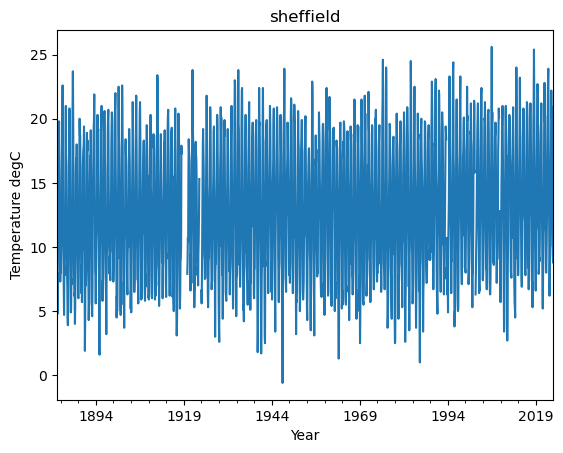

In [5]:
plot = station_data.plot_max_temp_figure()

### Creating custom classes

Classes are another way to group variables (attributes) and functions (methods).
Everything in Python is a class.
`dir` shows the attributes and methods that are present.
The private "__dunder__" methods determine class behaviour within Python.

In [6]:
my_integer = 1
print(f"type: {type(my_integer)}")
dir(my_integer)

type: <class 'int'>


['__abs__',
 '__add__',
 '__and__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 '__xor__',
 'as_integer_ratio',
 'bit_count',
 'bit_length',
 'conjugate',
 'denominator',
 'from_bytes',
 'imag',
 'is_integer',
 

A simple class needs a function (`__init__`) to initialise it.
A `__repr__` function defines how it is printed.
The methods of the class instance take `self` as the first parameter which allows them to access internal data.

Classes represent things, so their names are **nouns**, in _camelCase_.

In [7]:
class Sample:
    """A class to represent sample metadata."""
    def __init__(self, name: str):
        self.name = name

    def __repr__(self):
        return f"Sample({self.name})"


sample = Sample("JAS-032")
print(f"sample: {sample}")
print(f"type: {type(sample)}")
help(sample)

sample: Sample(JAS-032)
type: <class '__main__.Sample'>
Help on Sample in module __main__ object:

class Sample(builtins.object)
 |  Sample(name: str)
 |
 |  A class to represent sample metadata.
 |
 |  Methods defined here:
 |
 |  __init__(self, name: str)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



The attributes of a class are accessible via `.` notation.  Use `dir()` to list them all.

In [8]:
print(sample.name)

JAS-032



### Exercise

+ Give the sample a `description` attribute
+ Create a sample, then assign new values to the `name` and `description`

### Dataclasses

Dataclasses are a convenient way to store data with a __repr__ and __init__ and with type hints to help keep your code right.
This example is similar to a row from a database table.

In [9]:
@dataclasses.dataclass
class Sample:
    """A class to represent sample metadata."""
    name: str
    description: str
    collection_date: dt.date

sample = Sample(
    name="JAS-032",
    description="Chilled margin of dyke",
    collection_date=dt.date(2026, 1, 27)
)

print(sample)

# Attributes are accessed and updated using . notation
print(f"description: {sample.description}")
sample.name = "JAS-032-A"
print(f"new name: {sample.name}")

# Dataclasses can conveniently be turned into dictionaries or tuples
print(f"asdict: {dataclasses.asdict(sample)}")

Sample(name='JAS-032', description='Chilled margin of dyke', collection_date=datetime.date(2026, 1, 27))
description: Chilled margin of dyke
new name: JAS-032-A
asdict: {'name': 'JAS-032-A', 'description': 'Chilled margin of dyke', 'collection_date': datetime.date(2026, 1, 27)}


### Features of classes

Classes can have methods that act on their attributes.

In [10]:
@dataclasses.dataclass
class Sample:
    """A class to represent sample metadata."""
    name: str
    description: str
    collection_date: dt.date

    def age(self) -> int:
        """
        Return the number of days since the sample was collected.
        """
        delta = dt.date.today() - self.collection_date
        return delta.days


sample = Sample(
    name="JAS-032",
    description="Chilled margin of dyke",
    collection_date=dt.date(2025, 1, 27)
)

print(f"Age: {sample.age()} days")

Age: 365 days


Inheritance allows classes to reuse code.

In [11]:
@dataclasses.dataclass
class SoilSample(Sample):
    mass: float  # Sample mass in kg

@dataclasses.dataclass
class RiverSample(Sample):
    volume: float  # Sample volume in litres

my_soil = SoilSample(
    name="soil_123",
    description="Base of core",
    collection_date=dt.date(2021, 3, 2),
    mass=1.56
)

my_river_water = RiverSample(
    "water_123",
    "Beneath the outflow pipe",
    dt.date(2025, 8, 2),
    0.35
)

# Attributes from parent class are inherited
print(my_soil.name, my_soil.mass)
print(my_river_water.name, my_river_water.volume)

# So are methods
print(f"Soil sample age: {my_soil.age()} days")


soil_123 1.56
water_123 0.35
Soil sample age: 1792 days


Classes can modify their own data

In [12]:
@dataclasses.dataclass
class RiverSample(Sample):
    volume: float  # Sample volume in litres

    def extract_subsample(self, required_volume: float) -> float:
        """
        Attempt to remove required volume from sample.  Return
        actual volume extracted.
        """
        if self.volume >= required_volume:
            self.volume -= required_volume
            return required_volume
        else:
            available_volume = self.volume
            self.volume = 0
            return available_volume


my_river_water = RiverSample(
    name="water_123",
    description="Beneath the outflow pipe",
    collection_date=dt.date(2025, 8, 2),
    volume=0.35
)

for i in range(5):
    extracted_volume = my_river_water.extract_subsample(0.1)
    print(f"Extracted: {extracted_volume:.3f}, remaining: {my_river_water.volume:.3f}")


Extracted: 0.100, remaining: 0.250
Extracted: 0.100, remaining: 0.150
Extracted: 0.100, remaining: 0.050
Extracted: 0.050, remaining: 0.000
Extracted: 0.000, remaining: 0.000


#### Questions

+ Compare the main methods of the `class_version/plot_climate_data_classy.py` and `plot_climate_data_good.py` files.  How do they differ?
+ Look at the class definition in `class_version/historic_station_data.py`.  Some functions
  from `plot_climate_data_good` have become class methods.  What do they have in common?
+ Why does `historic_station_data.py` not have a `__name__ == "__main__"` section?


#### Exercise

+ Add a `summary_text()` method to the `HistoricStationData` class, based on the function
  that you wrote in the `pytest` section.  Update the tests to call it.
+ Update the `plot_climate_data_classy.py` script so that the logger outputs a summary
  for each file that it reads.

### Using LLMS for development

LLMs such as ChatGPT and MS Copilot can help with coding.
They often make mistakes, but so does Stack Overflow or Google.
If you use them at the level of a function, you can easily check the results
and make sure that you understand the code that they generate.
This is different to "vibe coding", where the user doesn't try to understand the code.

In [13]:
import random
llm = random.choice(["ChatGPT", "Copilot"])
print(f"Use {llm} for the following exercise.")

Use Copilot for the following exercise.


#### Exercise

We want to add latitude and longitude attributes to our HistoricStationData class.
These are found in the header of each of the data files.
Beware that not all headers are the same.

One approach is to write a function to extract the data from the file and call it in the `__init__`
of the class, as we do with the station name and data.

Here is a suggestion for a prompt to use.  Modify as required.

In [14]:
"""
I have a series of text files with headers like this:


Southampton
Location 442000E 112500N, 20 metres amsl (1855 to 1969) & 441600E 111200N, Lat 50.898 Lon -1.408, 3 metres amsl (1970 to 2000)
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.
   yyyy  mm   tmax    tmin      af    rain     sun
              degC    degC    days      mm   hours
   1855   1    5.0     0.5      16     ---     ---
   1855   2    2.4    -3.5      21    54.3     ---
   1855   3    7.9     0.8      12    61.3     ---


or


Tiree
Location: 99800E 744800N, Lat 56.500 Lon -6.880, 12 metres amsl
Estimated data is marked with a * after the value.
Missing data (more than 2 days missing in month) is marked by  ---.
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.
   yyyy  mm   tmax    tmin      af    rain     sun
              degC    degC    days      mm   hours
   1928   1    ---     ---     ---     ---    42.8
   1928   2    ---     ---     ---     ---    59.2
   1928   3    ---     ---     ---     ---    96.4


Write a Python function with the following signature:

`def get_lat_long(data_file: Path) -> tuple[float, float]`

The function should return the latest Lat and Lon values from the Location section of the header
that begins on the second line.
"""


'\nI have a series of text files with headers like this:\n\n\nSouthampton\nLocation 442000E 112500N, 20 metres amsl (1855 to 1969) & 441600E 111200N, Lat 50.898 Lon -1.408, 3 metres amsl (1970 to 2000)\nEstimated data is marked with a * after the value.\nMissing data (more than 2 days missing in month) is marked by  ---.\nSunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.\n   yyyy  mm   tmax    tmin      af    rain     sun\n              degC    degC    days      mm   hours\n   1855   1    5.0     0.5      16     ---     ---\n   1855   2    2.4    -3.5      21    54.3     ---\n   1855   3    7.9     0.8      12    61.3     ---\n\n\nor\n\n\nTiree\nLocation: 99800E 744800N, Lat 56.500 Lon -6.880, 12 metres amsl\nEstimated data is marked with a * after the value.\nMissing data (more than 2 days missing in month) is marked by  ---.\nSunshine data taken from an automatic Kipp & Zonen sensor marked with a 

+ For a bonus exercise, vibe code a script that will read all the files in the data directory and return a GeoJSON file with their locations that you can plot in QGIS.